In [2]:
import sys
sys.path.append("../py")
import transitTools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
SignalPlusNoiseCurve = loadtxt('../data/signalPlusNoiseCurve_00_0.txt')

In [4]:
totalObservingTimeInMinutes = 30*60
samplingRatePerMinute = 1
time = arange(0, totalObservingTimeInMinutes, samplingRatePerMinute)

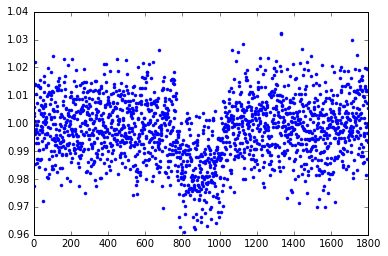

In [5]:
plot (SignalPlusNoiseCurve,'.')

In [6]:
# Measuring the noise out of transit

length=len(SignalPlusNoiseCurve)
SignalPlusNoiseCurve_pre=SignalPlusNoiseCurve[0:600]
SignalPlusNoiseCurve_post=SignalPlusNoiseCurve[1200:length]
noiseRange = concatenate((SignalPlusNoiseCurve_pre,SignalPlusNoiseCurve_post))

measured_noise=std(noiseRange)
print measured_noise

0.0102558134337


In [7]:
# Basic ways of getting the depth
depth1 = max(SignalPlusNoiseCurve)-min(SignalPlusNoiseCurve)
depth2 = 1-mean(SignalPlusNoiseCurve[775:1025])
depth2_length = len(SignalPlusNoiseCurve[775:1025])
print depth1,depth2

0.0715618281641 0.0156081142224


In [8]:
# Define tophat model
def tophat_model(t0=900,depth=0.01,dur=2*60.): # top hat model function
    modelSignal = ones(1800)
    modelSignal[(time >t0-(dur/2.)) & (time < t0+(dur/2.))]=1-depth
    return modelSignal

In [38]:
# Define trapezoid function
def trapezoid_model(t0=900,depth=0.01,dur=2*60.,inner_dur=2*60/2.):
    modelSignal = ones(1800)
    modelSignal[(time > t0-(inner_dur/2.)) & (time < t0+(inner_dur/2.))]=1-depth
    angle_sides = numpy.linspace(start=1, stop=1-depth, num=(dur-inner_dur)/2., endpoint=False)
    modelSignal[(time > t0-(dur/2.)) & (time <= t0-(inner_dur/2.))]=angle_sides
    modelSignal[(time < t0+(dur/2.)) & (time >= t0+(inner_dur/2.))]=angle_sides[::-1]
    return modelSignal

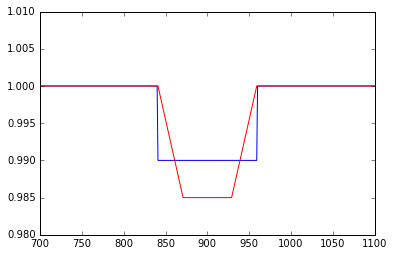

In [44]:
tophat = tophat_model()
plot (tophat)
ylim([0.98,1.01])
xlim([700,1100])
trap = trapezoid_model(t0=900,depth=0.015,dur=2*60.,inner_dur=2*60/2)
plot (trap, 'r')

0.0156081142224 250


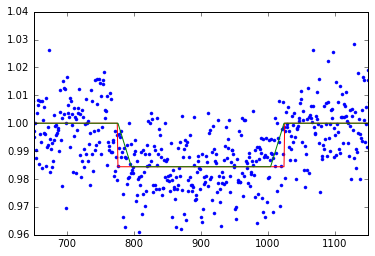

In [48]:
# Derive the depth using the duration instead of hard-coded indices
T0 = 900
dur = 250
tmin = T0-dur/2
tmax = T0+dur/2
depth3 = 1-mean(SignalPlusNoiseCurve[tmin:tmax])
depth3_length = len(SignalPlusNoiseCurve[tmin:tmax]) # this is equal to duration
print depth3,depth3_length

# Call tophat model
modelSignal = tophat_model(t0=T0,depth=depth3,dur=dur)

# Call trapezoid model
trapSignal = trapezoid_model(t0=T0,depth=depth3,dur=dur,inner_dur=dur/1.2)

# Plot curve
plot(SignalPlusNoiseCurve,'.')
xlim([650,1150])
plot (modelSignal,'r')
plot (trapSignal, 'g')

In [17]:
# Basic way of getting the signal to noise

signal_to_noise = depth3/measured_noise*depth3_length**0.5
print signal_to_noise 

24.0630308077


In [49]:
# Signal to noise using chi square

def chi_squared(noise,SignalPlusNoiseCurve,modelSignal):
    chi_squared_value = sum(((SignalPlusNoiseCurve-modelSignal)/noise)**2)
    return chi_squared_value
# note: this assumes that all data points have the same uncertainty and it is equal to measured_noise

# chi square from tophat
chi_squared_value = chi_squared(measured_noise,SignalPlusNoiseCurve,modelSignal)  

# chi square from trapezoid
chi_squared_value_trap = chi_squared(measured_noise,SignalPlusNoiseCurve,trapSignal)  

# chi square for the null hypothesis
chi_squared_value_null = chi_squared(measured_noise,SignalPlusNoiseCurve,ones(1800))  

# signal to noise from chi squares - tophat
signal_to_noise2 = sqrt(abs(chi_squared_value_null - chi_squared_value))

# signal to noise from chi squares - trapezoid
signal_to_noise_trap = sqrt(abs(chi_squared_value_null - chi_squared_value_trap))

print chi_squared_value,chi_squared_value_null,signal_to_noise2, signal_to_noise_trap


1776.10991167 2356.18601599 24.0847691355 23.998963383


In [41]:
sqrt(chi_squared_value_null / 1800.)

1.1441119836376863

In [26]:
import scipy.stats as stats
p_value = 1 - stats.chi2.cdf(x=chi_squared_value_null,  # Find the p-value
                             df=1800)

In [27]:
p_value

0.0

In [33]:
1 - stats.chi2.cdf(x=2300.,  # Find the p-value
                             df=1800.)

8.1046280797636427e-15